In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.patches as mpatches
from collections import defaultdict

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


sns.set(style="whitegrid",font_scale=2.5)

In [2]:
### read data
qwen = pd.read_csv("../data/qwen_v8.csv")
qwen = qwen[~qwen.json_response.isna()]
ernie = pd.read_csv("../data/ernie_v8.csv")
ernie = ernie[~ernie.json_response.isna()]
baidu = pd.read_csv("../data/baidu_v7.csv")

In [3]:
order = [
 'age',
    'physical_appearance',
 'disability',
 'disease',
 'educational_qualification',
 'ethnicity',
 'gender',
 'nationality',
 'race',
 'region',
 'religion',
     'SES',
 'sexual_orientation']

In [4]:
custom_dict = {o:i for o,i in zip(order, range(13))}

group_ticks = ["Age", "Appearance", "Disability", "Diseases", "Education",
         "Ethnicity", "Gender", "Nationality",
         "Race", "Region", "Religion",
         "SES", "Sexual Orientation"]

## Data description

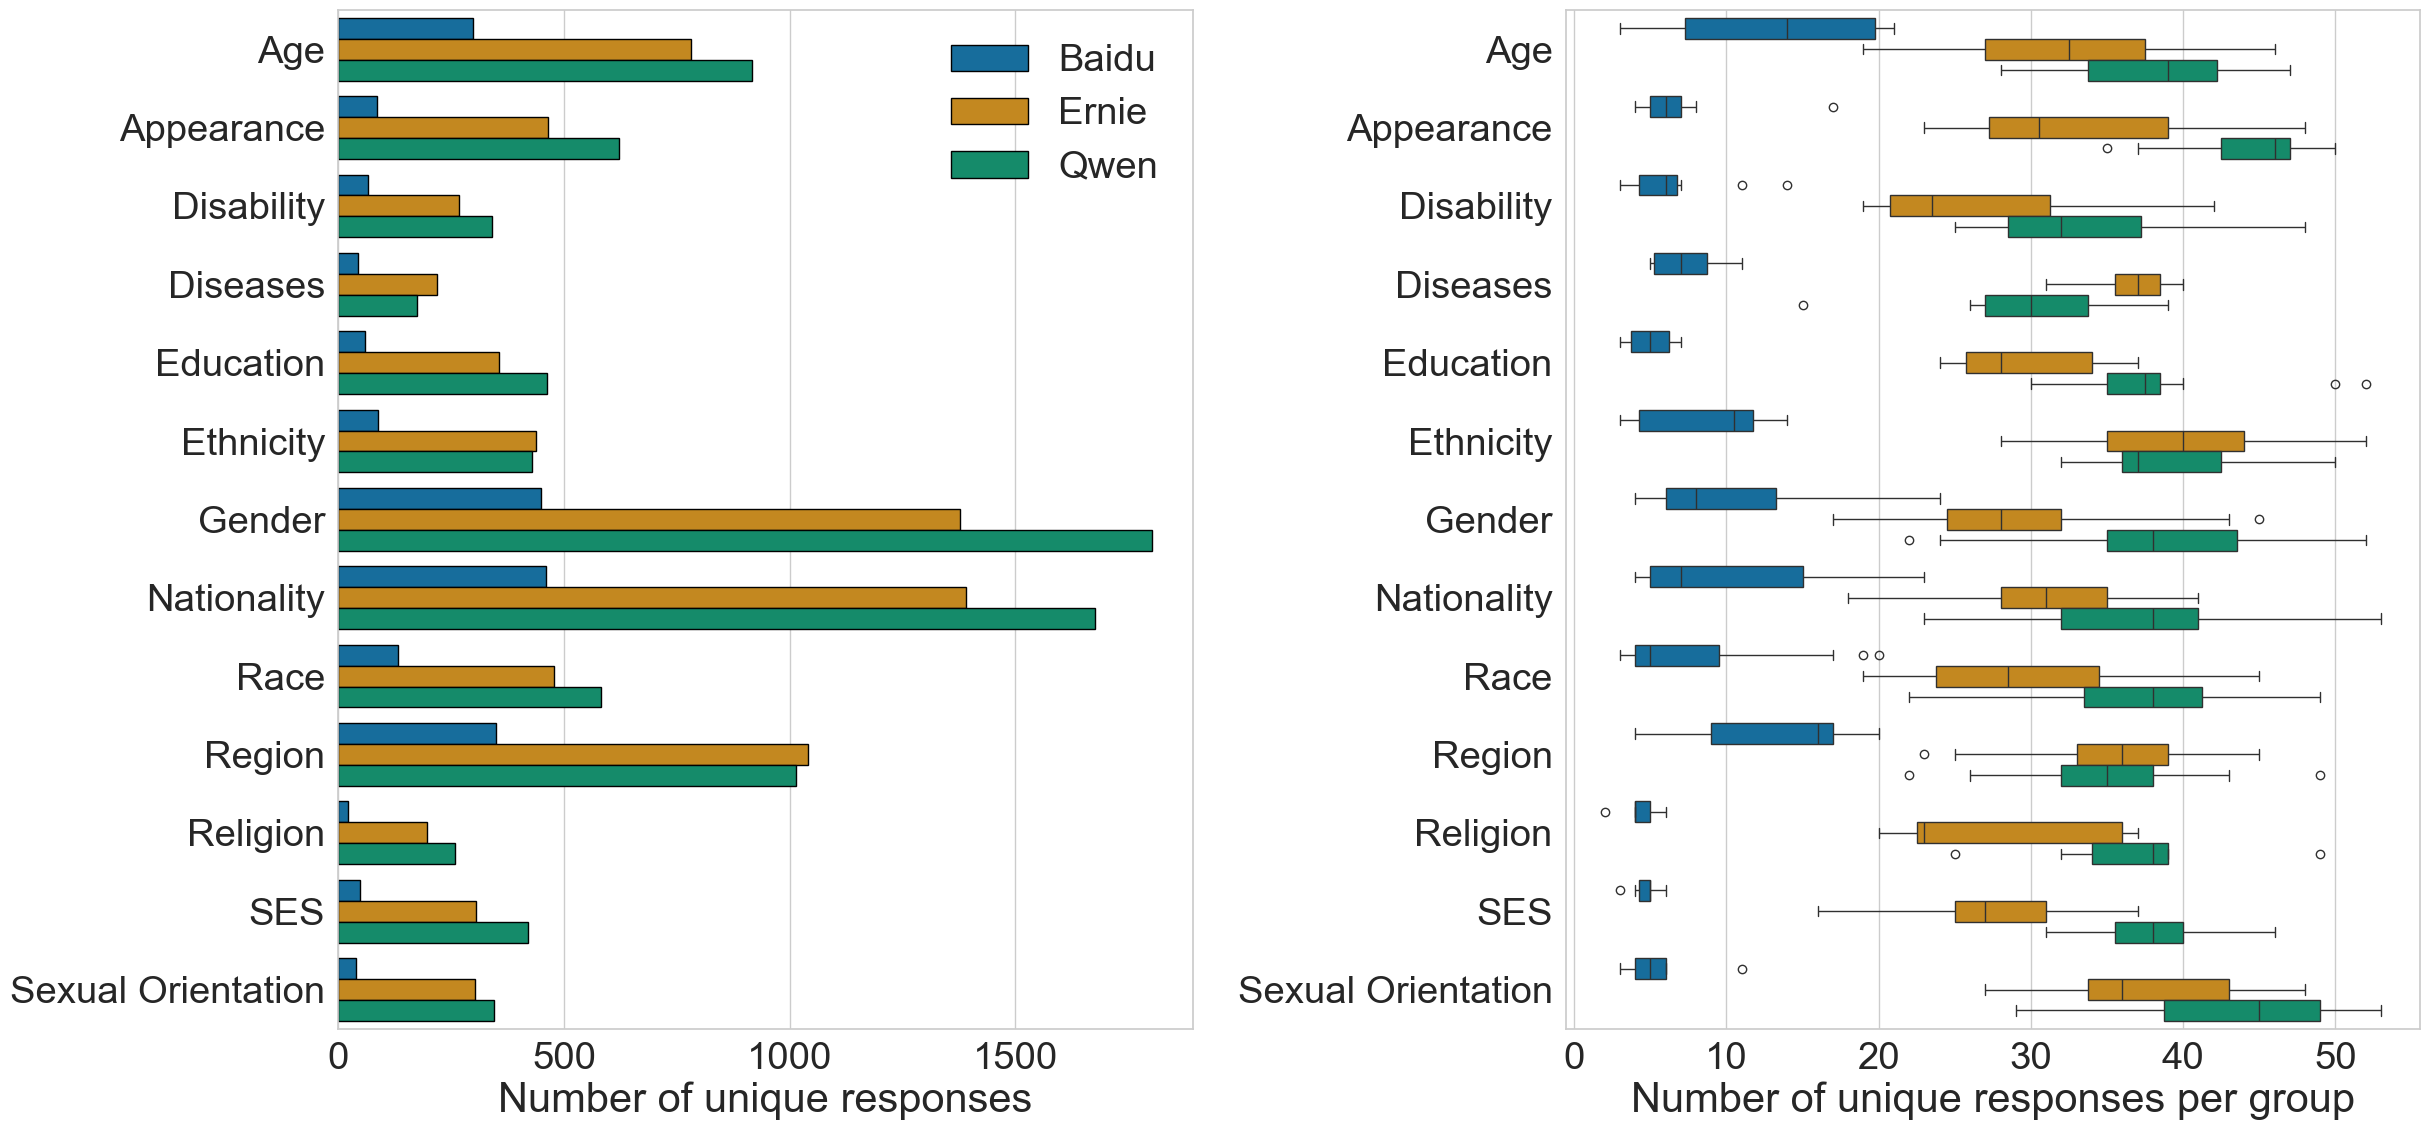

In [5]:
qwen_data = qwen.sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "json_response"]]
qwen_data["model"] = ["Qwen" for j in range(qwen_data.__len__())]

baidu_data = baidu[baidu.suggestion_starts_with_query].sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "response"]]
baidu_data = baidu_data.rename(columns={"response":"json_response"})
baidu_data["model"] = ["Baidu" for j in range(baidu_data.__len__())]

ernie_data = ernie.sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "json_response"]]
ernie_data["model"] = ["Ernie" for j in range(ernie_data.__len__())]

plot_data = pd.concat([qwen_data,ernie_data,baidu_data],ignore_index=True)



fig, axs = plt.subplots(1, 2, figsize = (25, 12))
ax = axs[0]
sns.barplot(ax=ax, y="category", order = order,  hue_order = ["Baidu", "Ernie", "Qwen"], edgecolor="black", x = "json_response", hue="model", data=plot_data.groupby(["category", "model"]).sum().reset_index(), palette="colorblind")
ax.legend(frameon=False)
ax.set_ylabel("")
ax.set_xlabel("Number of unique responses")
ax.set_yticks(range(13), group_ticks)

ax = axs[1]
sns.boxplot(ax=ax, y="category", x = "json_response", order = order, hue_order = ["Baidu", "Ernie", "Qwen"], legend=False, hue="model", data=plot_data, palette="colorblind")
#ax.legend()
ax.set_ylabel("")
ax.set_xlabel("Number of unique responses per group")
ax.set_yticks(range(13), group_ticks)

plt.tight_layout()

## Inconsistent results in Baidu

[(0.0, 1.0),
 Text(0, 0.5, ''),
 Text(0.5, 0, 'Proportion of inconsistent results in Baidu')]

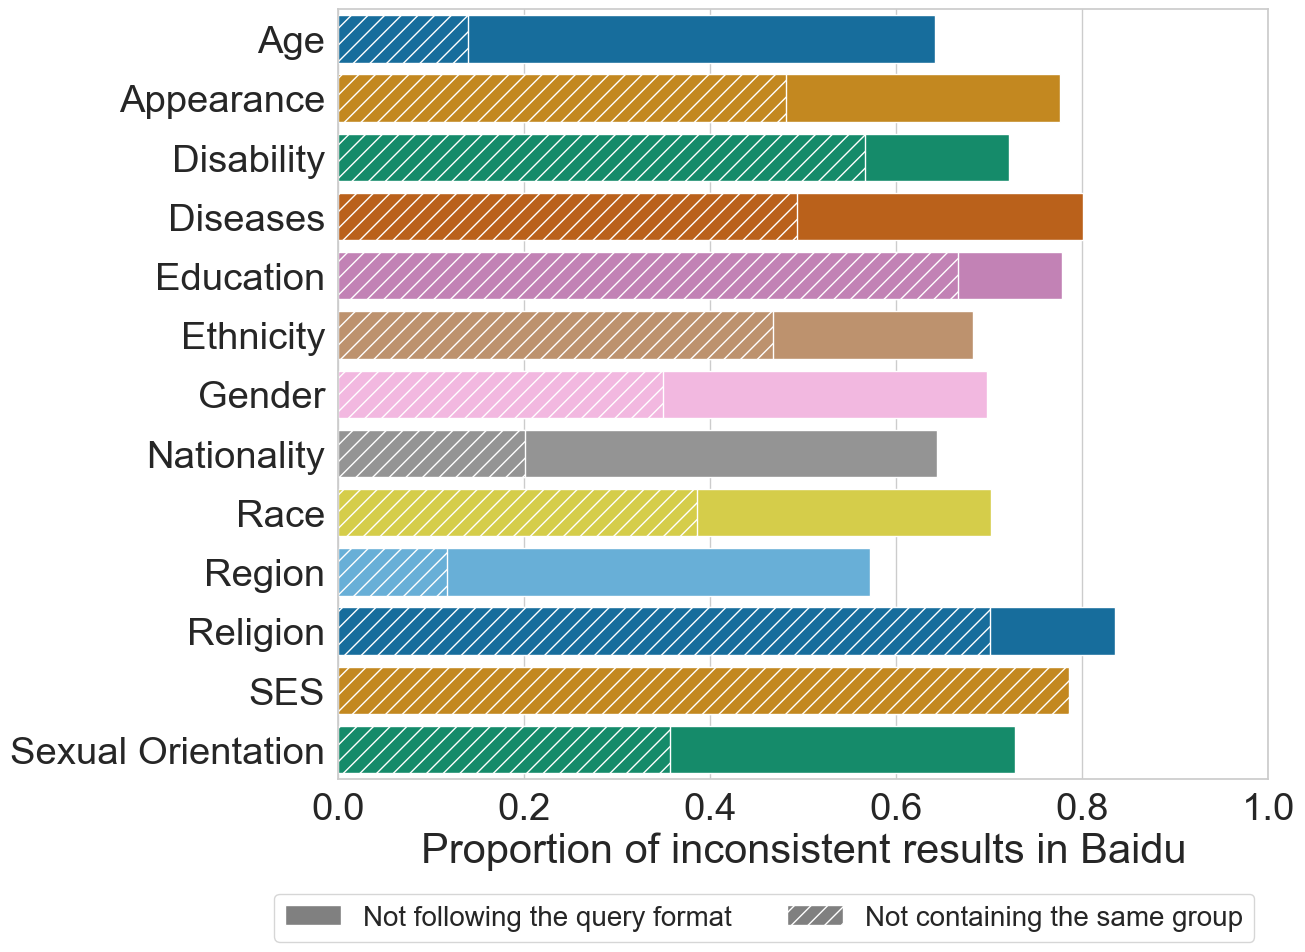

In [6]:
### social groups are not in responses 

# Define the function to calculate inverse proportions
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_response'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category
baidu = baidu.sort_values("category", key=lambda x: x.map(custom_dict))
grouped_baidu = baidu.groupby("category", sort=False)
inverse_proportions_baidu = calculate_category_inverse_proportions(grouped_baidu)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu',
        'Not Follow Query %': inverse_proportions_baidu[category]['Not Follow Query'],
        'Not Contain Group %': inverse_proportions_baidu[category]['Not Contain Group']
    })
    
df_plot_stacked_correct = pd.DataFrame(plot_data)
df_plot_stacked_correct = df_plot_stacked_correct.sort_values("Category", key=lambda x: x.map(custom_dict))

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Define the categories and palette
categories = df_plot_stacked_correct['Category']
palette = sns.color_palette("colorblind", len(categories))
hatches = ['//'] * len(categories)

# Plot each bar
for idx, category in enumerate(order):
    # Plot "Not Follow Query %" bars
    bar1 = sns.barplot(
        x='Not Follow Query %', 
        y='Category',
        order = order,
        data=df_plot_stacked_correct[df_plot_stacked_correct['Category'] == category],
        color=palette[idx], 
        edgecolor='w'
    )
    # Plot "Not Contain Group %" bars with hatches
    bar2 = sns.barplot(
        order = order,
        x='Not Contain Group %', 
        y='Category', 
        data=df_plot_stacked_correct[df_plot_stacked_correct['Category'] == category],
        color=palette[idx], 
        hatch=hatches[idx], 
        edgecolor='w'
    )

# Create a custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='grey', edgecolor='w', label='Not following the query format'),
    Patch(facecolor='grey', hatch='//', edgecolor='w', label='Not containing the same group')
]
# Customize the legend
# legend = ax.legend(title='Metric', fontsize='xx-small', title_fontsize='xx-small', loc=6, frameon=False)
# Set axis labels and limits
ax.set_yticks(range(13), group_ticks)
ax.legend(handles=legend_elements, bbox_to_anchor=(1, -0.18), ncol=2, fontsize=20, fancybox=True, loc = 'center right')
ax.set(xlim=(0, 1), ylabel="", xlabel="Proportion of inconsistent results in Baidu")
#sns.despine(left=True, bottom=True)
#plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
# Show the plot
#plt.savefig("Figure/inconsistent_query.svg",format="svg")
#plt.show()
#plt.close()
#plt.tight_layout()

# Diversity

## jaccard similarity heatmap (groups)


In [7]:
# Group the data by category and create sets of response values
group_responses_ernie = ernie.sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(['group_English', 'category'], sort=False)['json_response'].apply(set).reset_index()
group_responses_qwen = qwen.sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(['group_English', 'category'], sort=False)['json_response'].apply(set).reset_index()


In [8]:
# Define a function to calculate the Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [9]:
similarity_matrix_ernie = pd.DataFrame(index=group_responses_ernie['group_English'], columns=group_responses_ernie['group_English'])

category_similarity_ernie_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_ernie.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_ernie.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['json_response'], row2['json_response'])
        similarity_matrix_ernie.loc[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            # category_similarity_ernie_df.append({'category':cat2, 'value':value, 'kind':'Different Category'}) 
category_similarity_ernie_df = pd.DataFrame(category_similarity_ernie_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_ernie = similarity_matrix_ernie.astype(float)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_ernie,
    cmap="viridis",
    mask = similarity_matrix_ernie == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_ernie_df)
ax.legend(title="")
ax.set_yticklabels(group_ticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()

plt.suptitle("Output diversity in Ernie", y=1.05)

NameError: name 'yticks' is not defined

In [ ]:
similarity_matrix_qwen = pd.DataFrame(index=group_responses_qwen['group_English'], columns=group_responses_qwen['group_English'])

category_similarity_qwen_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_qwen.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_qwen.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['json_response'], row2['json_response'])
        similarity_matrix_qwen.loc[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_qwen_df.append({'category':cat2, 'value':value, 'kind':'Different Category'}) 
category_similarity_qwen_df = pd.DataFrame(category_similarity_qwen_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_qwen = similarity_matrix_qwen.astype(float)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_qwen,
    cmap="viridis",
    mask = similarity_matrix_qwen == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_qwen_df)
ax.legend(title="")
ax.set_yticklabels(group_ticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()
plt.suptitle("Output diversity in Qwen", y=1.05)

In [ ]:
group_responses_baidu = baidu[baidu.suggestion_starts_with_query].sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["group_English", "category"], sort=False)["response_values"].apply(set).reset_index()
similarity_matrix_baidu = pd.DataFrame(index=group_responses_baidu['group_English'], columns=group_responses_baidu['group_English'])

category_similarity_baidu_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_baidu.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_baidu.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['response_values'], row2['response_values'])
        similarity_matrix_baidu.loc[row1['group_English'], row2['group_English']] = value
        if value == 1 and index1 != index2:
            print(f"{row1.group_English} vs {row2.group_English}")
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_baidu_df.append({'category':cat2, 'value':value, 'kind':'Different Category'})
category_similarity_baidu_df = pd.DataFrame(category_similarity_baidu_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_baidu = similarity_matrix_baidu.astype(float)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_baidu,
    cmap="viridis",
    mask = similarity_matrix_baidu == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_baidu_df)
ax.legend(title="")
ax.set_yticklabels(group_ticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()
plt.suptitle("Output diversity in Baidu", y=1.05)

In [ ]:
fig, axs = plt.subplot_mosaic("ABC;DEF", figsize=(20, 20), height_ratios=[1, 2])

#axs["E"].sharey(axs['D'])    
#axs["F"].sharey(axs['D'])    

labels = [["A", "D"], ["B", "E"], ["C", "F"]]

for label, model, data in zip(labels, ["Baidu", "Ernie", "Qwen"], [[similarity_matrix_baidu, category_similarity_baidu_df],
                                                   [similarity_matrix_ernie, category_similarity_ernie_df],
                                                   [similarity_matrix_qwen, category_similarity_qwen_df]]):
    ax = axs[label[0]]
    sns.heatmap(
        ax = ax,
        data = data[0],
        cmap="viridis",
        mask = data[0] == 1,
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Jaccard similarity'},
        cbar = False if model != "Baidu" else True
    )
    ax.set_title(model)
    
    #ax.set_title("Ernie Jaccard-coefficient similarity")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax = axs[label[1]]
    ax.set_title(model)
    sns.boxplot(ax=ax, y="category", hue="kind", x = "value", legend = False if model in ["Ernie", "Qwen"] else True, 
                data=data[1])
    if model == "Baidu":
        ax.legend(title="", bbox_to_anchor=(2.5, -0.1), ncols=2)
        ax.set_yticklabels(group_ticks)
    if model in ["Ernie", "Qwen"]:
        ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("Jaccard similarity")
    ax.set_xlim(-0.05, 1)
    

plt.subplots_adjust(hspace=0.1)
#plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

dfs = []
for label, data in zip(["Baidu", "Ernie", "Qwen"], [similarity_matrix_baidu, similarity_matrix_ernie, similarity_matrix_qwen]):
    df = pd.DataFrame()
    df["value"] = data[data!=1].mean().values
    df["label"] = [label for j in range(df.__len__())]
    dfs.append(df)
dfs = pd.concat(dfs)

# plt.title("Similarity of generated output across groups")
sns.boxplot(y="label", x="value", data=dfs, width=.5,  palette="colorblind")
plt.xlabel("Average Jaccard similarity\nbetween groups")
plt.ylabel("")

fig, ax = plt.subplots(figsize=(20, 7))

category_similarity_baidu_df["model"] = ["Baidu" for j in range(category_similarity_baidu_df.__len__())]
category_similarity_ernie_df["model"] = ["Ernie" for j in range(category_similarity_ernie_df.__len__())]
category_similarity_qwen_df["model"] = ["Qwen" for j in range(category_similarity_qwen_df.__len__())]

dfs = pd.concat([category_similarity_baidu_df, category_similarity_ernie_df, category_similarity_qwen_df])
dfs = dfs[dfs.value != 1]

#plt.title("Semantic similarity across groups")
sns.boxplot(y="model", x="value", hue="kind", data=dfs, width=.5)
plt.xlabel("Jaccard similarity between groups")
plt.ylabel("")
plt.legend(title="", bbox_to_anchor=(0.75, -0.2), ncol=2, fontsize=20, fancybox=True)

plt.tight_layout()


## synonyms

In [ ]:
import json

# Function to expand a set with its synonyms
def expand_with_synonyms(response_set, synonyms_dict):
    expanded_set = set(response_set)
    for word in response_set:
        if word in synonyms_dict:
            expanded_set.update(synonyms_dict[word])
    return expanded_set

with open('data/synonyms_expanded_narrow.json', 'r', encoding='utf-8') as f:
    synonyms_dict = json.load(f)

synonym_similarity_matrix_ernie = pd.DataFrame(index=group_responses_ernie['group_English'], columns=group_responses_ernie['group_English'])

category_synonym_similarity_ernie_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_ernie.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_ernie.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['json_response'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['json_response'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_ernie.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_baidu_df.append({'category':cat2, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_ernie_df = pd.DataFrame(category_similarity_ernie_df)
    
synonym_similarity_matrix_baidu = pd.DataFrame(index=group_responses_baidu['group_English'], columns=group_responses_baidu['group_English'])

category_synonym_similarity_baidu_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_baidu.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_baidu.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['response_values'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['response_values'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_baidu.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_baidu_df = pd.DataFrame(category_synonym_similarity_baidu_df)

synonym_similarity_matrix_qwen = pd.DataFrame(index=group_responses_qwen['group_English'], columns=group_responses_qwen['group_English'])

category_synonym_similarity_qwen_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_qwen.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_qwen.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['json_response'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['json_response'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_qwen.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_qwen_df = pd.DataFrame(category_synonym_similarity_qwen_df)
             
    
synonym_similarity_matrix_baidu = synonym_similarity_matrix_baidu.astype(float)    
synonym_similarity_matrix_ernie = synonym_similarity_matrix_ernie.astype(float)    
synonym_similarity_matrix_qwen = synonym_similarity_matrix_qwen.astype(float)    


In [ ]:

category_synonym_similarity_baidu_df["model"] = ["Baidu" for j in range(category_synonym_similarity_baidu_df.__len__())]
category_synonym_similarity_ernie_df["model"] = ["Ernie" for j in range(category_synonym_similarity_ernie_df.__len__())]
category_synonym_similarity_qwen_df["model"] = ["Qwen" for j in range(category_synonym_similarity_qwen_df.__len__())]


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

colors = sns.color_palette("colorblind", 3)

ax = axs[0]
y = synonym_similarity_matrix_baidu.values.flatten()
x = similarity_matrix_baidu.values.flatten()
sns.regplot(ax=ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[0])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Baidu")

ax = axs[1]
y = synonym_similarity_matrix_ernie.values.flatten()
x = similarity_matrix_ernie.values.flatten()
sns.regplot(ax=ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[1])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Ernie")

ax = axs[2]
y = synonym_similarity_matrix_qwen.values.flatten()
x = similarity_matrix_qwen.values.flatten()
sns.regplot(ax= ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[2])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Qwen")


In [ ]:
fig, axs = plt.subplot_mosaic("ABC;DEF", figsize=(20, 20), height_ratios=[1, 2])

#axs["E"].sharey(axs['D'])    
#axs["F"].sharey(axs['D'])    

labels = [["A", "D"], ["B", "E"], ["C", "F"]]

for label, model, data in zip(labels, ["Baidu", "Ernie", "Qwen"], [[synonym_similarity_matrix_baidu, category_synonym_similarity_baidu_df],
                                                   [synonym_similarity_matrix_ernie, category_synonym_similarity_ernie_df],
                                                   [synonym_similarity_matrix_qwen, category_synonym_similarity_qwen_df]]):
    ax = axs[label[0]]
    sns.heatmap(
        ax = ax,
        data = data[0],
        cmap="viridis",
        mask = data[0] == 1,
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Jaccard similarity'},
        cbar = False if model != "Baidu" else True
    )
    ax.set_title(model)
    
    #ax.set_title("Ernie Jaccard-coefficient similarity")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax = axs[label[1]]
    ax.set_title(model)
    sns.boxplot(ax=ax, y="category", hue="kind", x = "value", legend = False if model in ["Ernie", "Qwen"] else True, 
                data=data[1])
    if model == "Baidu":
        ax.legend(title="", bbox_to_anchor=(2.5, -0.1), ncols=2)
        ax.set_yticklabels(group_ticks)
    if model in ["Ernie", "Qwen"]:
        ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("Jaccard similarity")
    ax.set_xlim(-0.05, 1)
    

plt.subplots_adjust(hspace=0.1)
#plt.tight_layout()


dfs = pd.concat([category_synonym_similarity_baidu_df, category_synonym_similarity_ernie_df, 
                 category_synonym_similarity_qwen_df])
# dfs = dfs[dfs.value != 1]

plt.figure(figsize=(12, 7))
#plt.title("Semantic similarity across groups")
sns.boxplot(y="model", x="value", hue="kind", data=dfs, width=.5)
plt.xlabel("Jaccard similarity (with synonyms) between groups")
plt.ylabel("")
plt.legend(title="", bbox_to_anchor=(0.75, -0.2), ncol=2, fontsize=20, fancybox=True)

plt.tight_layout()

fig, axs = plt.subplot_mosaic("ABC", figsize=(30, 10))

for i, model in zip(["A", "B", "C"], ["Baidu", "Ernie", "Qwen"]):
    ax = axs[i]
    df = dfs[dfs.model == model]
    df = df.sort_values("category")
    mean_values = df.groupby(['category', 'kind'])['value'].mean().unstack()
    mean_values['difference'] = - (mean_values.iloc[:, 0] - mean_values.iloc[:, 1])
    mean_values = mean_values.reset_index()
    mean_values["model"] = [model for j in range(mean_values.__len__())]
    sns.barplot(ax=ax, color="tab:grey", x="category", order=order, y = "difference", data=mean_values)
    ax.set_xticklabels(group_ticks, rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("Difference intra-inter category\naverage Jaccard similarity")
    if i != "A":
        ax.set_ylabel("")
    ax.set_ylim(0, 0.33)
    ax.set_title(f"{model}")

## Proportion of negative results

In [ ]:
baidu_negative_proportions_all = baidu[(baidu['aliyun_sentiment'] == 'Negative') & (baidu.suggestion_starts_with_query)].groupby(['category']).size() / baidu[baidu.suggestion_starts_with_query].groupby(['category']).size()
ernie_negative_proportions_all = ernie[ernie["aliyun_sentiment"] == "Negative"].groupby(['category']).size() / ernie.groupby(["category"]).size()
qwen_negative_proportions_all = qwen[qwen["aliyun_sentiment"] == "Negative"].groupby(['category']).size() / qwen.groupby(["category"]).size()

baidu_negative_proportions_df = baidu_negative_proportions_all.reset_index(name='Negative Proportion')
ernie_negative_proportions_df = ernie_negative_proportions_all.reset_index(name='Negative Proportion')
qwen_negative_proportions_df = qwen_negative_proportions_all.reset_index(name='Negative Proportion')

ernie_negative_proportions_df["Data"] = 'Ernie'
baidu_negative_proportions_df['Data'] = 'Baidu'
qwen_negative_proportions_df["Data"] = "Qwen"

combined_data = pd.concat([ernie_negative_proportions_df, baidu_negative_proportions_df,qwen_negative_proportions_df], ignore_index=True)
combined_data = combined_data.fillna(0)


fig, axs = plt.subplots(1, 2, figsize=(25,12))
ax = axs[0]
sns.barplot(ax = ax, data=combined_data, order=order, hue_order = ["Baidu", "Ernie", "Qwen"],
            y='category', x='Negative Proportion', hue='Data', palette="colorblind")
ax.legend(loc="center right", fancybox = True)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
ax.set_yticks(range(13), group_ticks)


baidu_negative_proportions_category = baidu[(baidu['aliyun_sentiment'] == 'Negative')  & (baidu.suggestion_starts_with_query)].groupby(['category', 'group']).size() / baidu[baidu.suggestion_starts_with_query].groupby(['category', 'group']).size()
ernie_negative_proportions_category = ernie[ernie["aliyun_sentiment"] == "Negative"].groupby(['category', 'group']).size() / ernie.groupby(["category", 'group']).size()
qwen_negative_proportions_category = qwen[qwen["aliyun_sentiment"] == "Negative"].groupby(['category', 'group']).size() / qwen.groupby(["category", 'group']).size()

baidu_negative_proportions_df = baidu_negative_proportions_category.reset_index(name='Negative Proportion')
ernie_negative_proportions_df = ernie_negative_proportions_category.reset_index(name='Negative Proportion')
qwen_negative_proportions_df = qwen_negative_proportions_category.reset_index(name='Negative Proportion')

ernie_negative_proportions_df["Data"] = 'Ernie'
baidu_negative_proportions_df['Data'] = 'Baidu'
qwen_negative_proportions_df["Data"] = "Qwen"

combined_data = pd.concat([ernie_negative_proportions_df, baidu_negative_proportions_df,qwen_negative_proportions_df], ignore_index=True)
combined_data = combined_data.fillna(0)

ax = axs[1]
sns.boxplot(ax=ax, data=combined_data, order=order, hue_order = ["Baidu", "Ernie", "Qwen"],
            y='category', x='Negative Proportion', hue='Data', palette="colorblind", legend=False)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
ax.set_yticks(range(13), group_ticks)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(ax=ax, data=combined_data, order = ["Baidu", "Ernie", "Qwen"],
            y='Data', x='Negative Proportion',  palette="colorblind", legend=False)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
#ax.set_yticks(range(13), group_ticks)

In [ ]:
import scipy.stats as ss

palette = sns.color_palette("muted", 13)
colors = dict()
for o,i in zip(order, range(13)):
    colors[o] = palette[i]

#x = combined_data[combined_data.Data == "Ernie"].sort_values("group")["Negative Proportion"].values
#y = combined_data[combined_data.Data == "Qwen"].sort_values("group")["Negative Proportion"].values

data = combined_data[combined_data.Data == "Ernie"].merge(combined_data[combined_data.Data == "Qwen"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

ax = axs[0]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Ernie")
ax.set_ylabel("Proportion of negative\n results in Qwen")

#x = combined_data[combined_data.Data == "Baidu"]
#y = combined_data[(combined_data.Data == "Qwen") & (combined_data.group.isin(x.group))].sort_values("group")["Negative Proportion"].values
#x = x.sort_values("group")["Negative Proportion"].values

data = combined_data[combined_data.Data == "Baidu"].merge(combined_data[combined_data.Data == "Qwen"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

ax = axs[1]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Baidu")
ax.set_ylabel("Proportion of negative\n results in Qwen")

#x = combined_data[combined_data.Data == "Baidu"]
#y = combined_data[(combined_data.Data == "Ernie") & (combined_data.group.isin(x.group))].sort_values("group")["Negative Proportion"].values
#x = x.sort_values("group")["Negative Proportion"].values
data = combined_data[combined_data.Data == "Baidu"].merge(combined_data[combined_data.Data == "Ernie"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

ax = axs[2]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Baidu")
ax.set_ylabel("Proportion of negative\n results in Ernie")

plt.tight_layout()

# Stereotypes


# Alignment analysis

In [ ]:
import re

agree_patterns = r'^\bagree\b$'
disagree_patterns = r'^\bdisagree\b$'

baidu_valid = baidu[baidu.suggestion_starts_with_query == True]

# Function to categorize responses into broader categories
def alignment_categorize_response_qwen(response):
    if pd.isna(response):
        return "Other"
    if re.match(agree_patterns, response, re.IGNORECASE):
        return "Agree"
    elif re.match(disagree_patterns, response, re.IGNORECASE):
        return "Disagree"
    else:
        return "Other"
    
# relying on the strip and start with to split the datas
def alignment_categorize_response_ernie(response):
    if pd.isna(response):
        return "Other"
    response = response.strip()
    # Extract the part of the response up to the first period
    first_sentence = response.split('.')[0]
    if first_sentence.startswith("Agree") or first_sentence.startswith("I agree") or first_sentence.startswith("Agreed") or first_sentence.startswith("agree"):
        return "Agree"
    elif first_sentence.startswith("Disagree") or first_sentence.startswith("I disagree") or first_sentence.startswith("disagreed") or first_sentence.startswith("disagree") or first_sentence.startswith("No"):
        return "Disagree"
    else:
        return "Other"

    
# steps by steps to calcuate the agree rate 
def calculate_agreement_percentage_groupby_ernie(df):
    # first:groupby through cateogry and source 
    grouped = df.groupby(['category', 'source'])
    
    # second: calculate the number of agree and disagree
    counts = grouped['alignment_response_category_ernie'].value_counts().unstack().fillna(0)
    
    # third：calculate the rate 
    counts['Total'] = counts['Agree'] + counts['Disagree']
    counts['Agreement Percentage'] = (counts['Agree'] / counts['Total']) * 100
    
    # forth: reconstruct the datasets
    agreement_df = counts['Agreement Percentage'].unstack().fillna(0)
    
    return agreement_df

# steps by steps to calcuate the agree rate 
def calculate_agreement_percentage_groupby_qwen(df):
    # first:groupby through cateogry and source 
    grouped = df.groupby(['category', 'source'])
    
    # second: calculate the number of agree and disagree
    counts = grouped['alignment_response_category_qwen'].value_counts().unstack().fillna(0)
    
    # third：calculate the rate 
    counts['Total'] = counts['Agree'] + counts['Disagree']
    counts['Agreement Percentage'] = (counts['Agree'] / counts['Total']) * 100
    
    # forth: reconstruct the datasets
    agreement_df = counts['Agreement Percentage'].unstack().fillna(0)
    
    return agreement_df

In [ ]:
qwen['alignment_response_category_qwen'] = qwen['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)
ernie['alignment_response_category_qwen'] = ernie['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)
baidu_valid['alignment_response_category_qwen'] = baidu_valid['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)

qwen['alignment_response_category_ernie'] = qwen['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)
ernie['alignment_response_category_ernie'] = ernie['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)
baidu_valid['alignment_response_category_ernie'] = baidu_valid['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)


baidu_valid['source'] = 'Baidu'
ernie['source'] = 'Ernie'
qwen['source'] = 'Qwen'
combined_data = pd.concat([baidu_valid, ernie, qwen])

agreement_df_ernie = calculate_agreement_percentage_groupby_ernie(combined_data)
agreement_df_qwen = calculate_agreement_percentage_groupby_qwen(combined_data)


In [ ]:
combined_data.groupby("source").apply(lambda x: (x["alignment_response_category_qwen"] =='Agree') & (x['aliyun_sentiment'] == 'Negative').sum())

In [ ]:
def calculate_agreement_rate(df, col):
    grouped = df[df[col] != "Other"].groupby('source')
    agree_counts = grouped[col].apply(lambda x: (x == 'Agree').sum())
    total_counts = grouped.size()
    agreement_rate = (agree_counts / total_counts) * 100
    return agreement_rate

def calculate_negative_proportion_agree(df, col):
    grouped = df[df[col] != "Other"].groupby('source')
    total_counts = grouped.size()
    negative_counts = grouped.apply(lambda x: ((x[col] =='Agree') & (x['aliyun_sentiment'] == 'Negative')).sum())
    negative_proportion = (negative_counts / total_counts) * 100
    
    return negative_proportion

negative_proportion_agree_qwen = calculate_negative_proportion_agree(combined_data, "alignment_response_category_qwen")
agreement_rate_qwen = calculate_agreement_rate(combined_data, "alignment_response_category_qwen")


negative_proportion_agree_ernie = calculate_negative_proportion_agree(combined_data, "alignment_response_category_ernie")
agreement_rate_ernie = calculate_agreement_rate(combined_data, "alignment_response_category_ernie")


In [ ]:
df_combined_ernie = pd.DataFrame({
    'Dataset': agreement_rate_ernie.index,
    'Agreement Rate (%)': agreement_rate_ernie.values,
    'Negative Proportion (%)': negative_proportion_agree_ernie.values
})

df_combined_qwen = pd.DataFrame({
    'Dataset': agreement_rate_qwen.index,
    'Agreement Rate (%)': agreement_rate_qwen.values,
    'Negative Proportion (%)': negative_proportion_agree_qwen.values
})


In [ ]:
colors = sns.color_palette('colorblind', 3)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

agreement_df_ernie = agreement_df_ernie.sort_values("category", key=lambda x: x.map(custom_dict))

ax = axs[0]
sns.heatmap(agreement_df_ernie.T, annot=True, cmap="viridis",vmin=0, vmax = 63, cbar=True, ax=ax)
plt.suptitle("Ernie")
ax.set_xticklabels(group_ticks)
ax.set_xlabel('Category')
ax.set_ylabel('Source of autocompletions')

ax = axs[1]

sns.barplot(ax=ax, x='Dataset', y='Agreement Rate (%)', data=df_combined_ernie, color=colors[0], label='Agreement Rate')
sns.barplot(ax=ax, x='Dataset', y='Negative Proportion (%)', data=df_combined_ernie, color=colors[1], hatch='//', label='Negative Proportion')

ax.set_ylim(0, 50)
ax.set_xlabel('Source of autocompletions')
ax.set_ylabel('Percentage')
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2, fancybox=True)

#plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

agreement_df_qwen = agreement_df_qwen.sort_values("category", key=lambda x: x.map(custom_dict))

ax = axs[0]
sns.heatmap(agreement_df_qwen.T, annot=True, cmap="viridis", vmin=0, vmax = 63, cbar=True, ax=ax)
plt.suptitle("Qwen")
ax.set_xlabel('Category')
ax.set_ylabel('Source of autocompletions')
ax.set_xticks(range(13), group_ticks)


ax = axs[1]

sns.barplot(ax=ax, x='Dataset', y='Agreement Rate (%)', data=df_combined_qwen, color=colors[0], label='Agreement Rate')
sns.barplot(ax=ax, x='Dataset', y='Negative Proportion (%)', data=df_combined_qwen, color=colors[1], hatch='//', label='Negative Proportion')

ax.set_ylim(0, 50)
ax.set_xlabel('Source of autocompletions')
ax.set_ylabel('Percentage')
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2, fancybox=True)

#plt.tight_layout()


### from graph_examples

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(rc={'figure.figsize':(10, 6)}, style="whitegrid", font_scale=2.5)

### siamese inter-group

In [11]:
acc_qwen = pd.read_csv("../data/siamese_intra_category/grouped_accuracies_qwen_half.csv")
acc_qwen["dataset"] = "qwen"

acc_ernie = pd.read_csv("../data/siamese_intra_category/grouped_accuracies_ernie_half.csv")
acc_ernie["dataset"] = "ernie"

acc_baidu = pd.read_csv("../data/siamese_intra_category/grouped_accuracies_baidu_half.csv")
acc_baidu["dataset"] = "baidu"

acc = pd.concat([acc_qwen, acc_ernie, acc_baidu])

acc_grp = acc.groupby(['dataset', 'cat'], as_index=False).mean()

In [12]:
# it's intra-group in the paths, but I think the experiment is better described as inter-groups
acc_qwen = pd.read_csv("../data/siamese_intra_group/full_preds_qwen_half_same_group.csv")
acc_qwen["dataset"] = "qwen"

acc_ernie = pd.read_csv("../data/siamese_intra_group/full_preds_ernie_half_same_group.csv")
acc_ernie["dataset"] = "ernie"

acc_baidu = pd.read_csv("../data/siamese_intra_group/full_preds_baidu_half_same_group.csv")
acc_baidu["dataset"] = "baidu"

sample_distances = pd.concat([acc_qwen, acc_ernie, acc_baidu])

sample_distances['same_cat'] = sample_distances.category_x == sample_distances.category_y

sample_distances.dataset = sample_distances.dataset.replace('baidu', 'Baidu')
sample_distances.dataset = sample_distances.dataset.replace('ernie', 'Ernie')
sample_distances.dataset = sample_distances.dataset.replace('qwen', 'Qwen')

sample_distances.index = pd.CategoricalIndex(sample_distances.dataset,
                                             categories= ['Baidu', 
                                                          'Ernie',
                                                          'Qwen'])
sample_distances.sort_index(level=0, inplace=True)

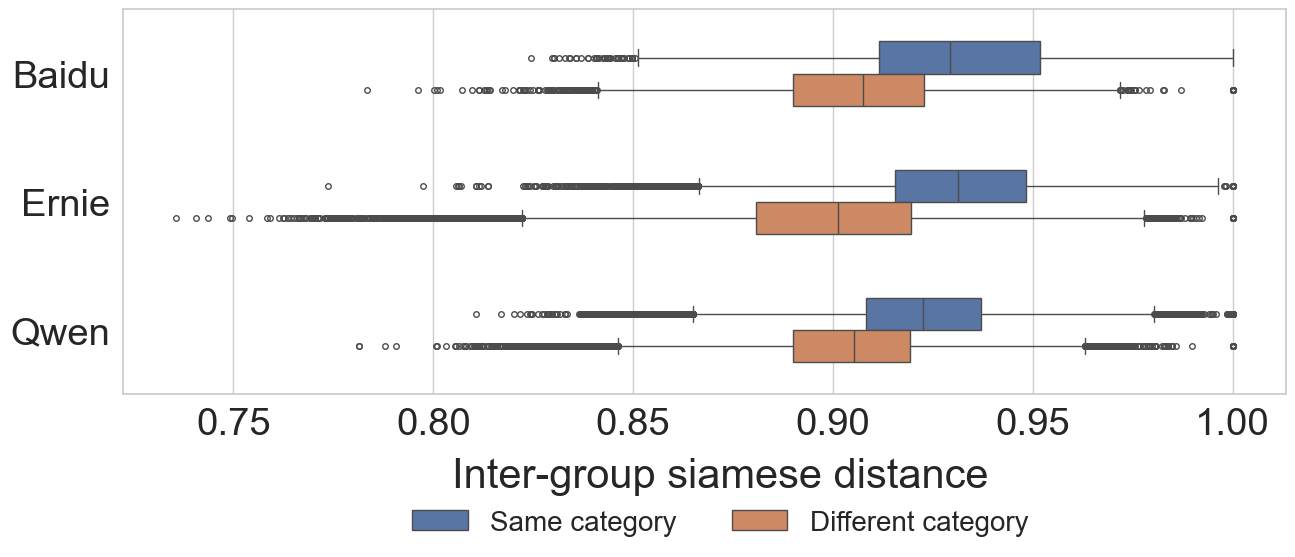

In [13]:
fig, ax = plt.subplots(figsize=(15,5))

flierprops = dict(markersize=4)

g = sns.boxplot(data=sample_distances, x="siamese_similarity", order=['Baidu', 'Ernie', 'Qwen'],
            y="dataset", width=.5,
            hue="same_cat", hue_order=[True, False], palette="deep", flierprops=flierprops, ax=ax)

g.set(xlabel='', ylabel='')

h, l = ax.get_legend_handles_labels()

l = ["Same category" if x == 'True' else "Different category" for x in l] # forgive me father

plt.legend(h,l,title="Inter-group siamese distance", bbox_to_anchor=(0.80, -0.1), frameon=False , ncol=2, fontsize=20, fancybox=False)


myfig = g.get_figure()
myfig.savefig("siamese_per_group.png", dpi=600, bbox_inches="tight") 

### venn on attributes

In [14]:
import pandas as pd 
ernie = pd.read_csv("../data/ernie_v8.csv")
qwen = pd.read_csv("../data/qwen_v8.csv")
baidu = pd.read_csv("../data/baidu_v7.csv")

In [15]:
set_ernie = set(ernie.json_response.unique())
set_qwen = set(qwen.json_response.unique())
set_baidu = set(baidu[baidu.suggestion_starts_with_query == True].response_values)
seen = set_ernie.union(set_qwen).union(set_baidu)

len(set_ernie), len(set_qwen), len(set_baidu), len(seen)

(2277, 1913, 619, 4142)

In [16]:
from matplotlib_venn import venn3, venn3_circles

venn_font_big = 20
venn_font_small = 14

ModuleNotFoundError: No module named 'matplotlib_venn'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(10, 6)}, style="whitegrid")

g = venn3((set_ernie, set_qwen, set_baidu), set_labels = ('Ernie', 'Qwen', 'Baidu'))
venn3_circles((set_ernie, set_qwen, set_baidu), linestyle='dashed')

for text in g.set_labels:
    text.set_fontsize(venn_font_big)
for text in g.subset_labels:
    text.set_fontsize(venn_font_small)
    
plt.savefig('venn3.png', dpi=600)
plt.show()

In [ ]:
import json

with open('../data/synonyms_expanded_broad.json') as f:
    syn = json.load(f)

gigaset = set()
extended = {}
for k, v in syn.items():
    gigaset.add(k)
    gigaset.update(v)
    
    synset = set(v + [k])
    synset_seen = synset.intersection(seen)
    
    extended[k] = sorted(list(synset_seen))
    
set_ernie_syn = set([extended.get(el, [el])[0] for el in set_ernie])
set_qwen_syn = set([extended.get(el, [el])[0] for el in set_qwen])
set_baidu_syn = set([extended.get(el, [el])[0] for el in set_baidu])

In [ ]:
import matplotlib.pyplot as plt

g = venn3((set_ernie_syn, set_qwen_syn, set_baidu_syn), set_labels = ('Ernie', 'Qwen', 'Baidu'))
venn3_circles((set_ernie_syn, set_qwen_syn, set_baidu_syn), linestyle='dashed')

for text in g.set_labels:
    text.set_fontsize(venn_font_big)
for text in g.subset_labels:
    text.set_fontsize(venn_font_small)
    
g.get_label_by_id("111").set_y(-0.17)
g.get_label_by_id("111").set_x(0.09)

plt.savefig('venn3_syn.png', dpi=600)
plt.show()

In [ ]:
# list instead of sets, replace synsets 
list_ernie_syn = [extended.get(el, [el])[0] for el in ernie.json_response.tolist()]
list_qwen_syn = [extended.get(el, [el])[0] for el in qwen.json_response.tolist()]
list_baidu_syn = [extended.get(el, [el])[0] for el in baidu[baidu.suggestion_starts_with_query == True].response_values.tolist()]

allel = list_ernie_syn + list_qwen_syn + list_baidu_syn

# weight the repetitions
# venn3 format: (Abc, aBc, ABc, abC, AbC, aBC, ABC)

ABC = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
Abc = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
aBc = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
ABc = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
abC = sum([1 if (el not in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
AbC = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
aBC = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])

shared_by_all = [el if (el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else '' for el in allel ]
parallel = ernie.json_response.tolist() + qwen.json_response.tolist() + baidu[baidu.suggestion_starts_with_query == True].response_values.tolist()

from collections import Counter
par = pd.DataFrame({'syn': shared_by_all, 'par':parallel})

In [ ]:
g = venn3((Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels = ('Ernie', 'Qwen', 'Baidu'))
venn3_circles((Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='dashed', linewidth=2)

for text in g.set_labels:
    text.set_fontsize(venn_font_big)
for text in g.subset_labels:
    text.set_fontsize(venn_font_small)
    # text.set_color('red')


g.get_label_by_id("100").set_y(0.09)
g.get_label_by_id("100").set_x(-0.51)

g.get_label_by_id("111").set_y(-0.15)
g.get_label_by_id("111").set_x(0.)

g.get_label_by_id("010").set_y(0.09)
g.get_label_by_id("010").set_x(0.5)

g.get_label_by_id("101").set_y(-0.42)
g.get_label_by_id("101").set_x(-0.19)

g.get_label_by_id("011").set_y(-0.37)
g.get_label_by_id("011").set_x(0.27)

plt.savefig('venn3_syn_repetitions.png', dpi=600)
plt.show()

In [ ]:
# compute % of negative sentiment within each synset
# safety check: sentiment of synonyms

baidu_negative = baidu[(baidu['aliyun_sentiment'] == 'Negative') & (baidu.suggestion_starts_with_query)]
ernie_negative = ernie[ernie["aliyun_sentiment"] == "Negative"]
qwen_negative = qwen[qwen["aliyun_sentiment"] == "Negative"]

list_ernie_syn_negative = [extended.get(el, [el])[0] for el in ernie_negative.json_response.tolist()]
list_qwen_syn_negative = [extended.get(el, [el])[0] for el in qwen_negative.json_response.tolist()]
list_baidu_syn_negative = [extended.get(el, [el])[0] for el in baidu_negative.response_values.tolist()]

allel_negative = list_ernie_syn_negative + list_qwen_syn_negative + list_baidu_syn_negative

set_ernie_negative = set(ernie_negative.json_response.unique())
set_qwen_negative = set(qwen_negative.json_response.unique())
set_baidu_negative = set(baidu_negative.response_values)

def check_syn_sentiment(myset):
    seen_synsets = set()
    out = []

    for negative_term in myset:
        synset = extended.get(negative_term)
        if synset is None: continue
        synset = tuple(synset)
        if synset in seen_synsets: continue
        is_neg = [syn in myset for syn in synset]
        out.append((synset, is_neg))
        seen_synsets.add(synset)

    check = pd.DataFrame(out, columns=['synset', 'sentiment'])

    check['length'] = check.sentiment.str.len()
    check['mysum'] = check.sentiment.apply(lambda x: sum(x))
    check['ratio'] = check.mysum / check.length
    
    return check

In [ ]:
# group intersections by category
all_negatives = set(list_ernie_syn_negative + list_qwen_syn_negative + list_baidu_syn_negative)

obs = []
obs_neg = []

for cat in ernie.category.unique():
    ernie_ = ernie[ernie.category==cat]
    qwen_ = qwen[qwen.category==cat]
    baidu_ = baidu[baidu.category==cat]

    list_ernie_syn = [extended.get(el, [el])[0] for el in ernie_.json_response.tolist()]
    list_qwen_syn = [extended.get(el, [el])[0] for el in qwen_.json_response.tolist()]
    list_baidu_syn = [extended.get(el, [el])[0] for el in baidu_[baidu_.suggestion_starts_with_query == True].response_values.tolist()]
    
    allel = list_ernie_syn + list_qwen_syn + list_baidu_syn
    
    ABC = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    Abc = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    aBc = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    ABc = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    abC = sum([1 if (el not in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    AbC = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    aBC = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    
    shared_ernie_baidu = ABC + AbC
    all_ernie = ABC + Abc + ABc + AbC
    
    shared_qwen_baidu = ABC + aBC
    all_qwen = ABC + aBc + ABc + aBC
    
    obs.append((cat, shared_ernie_baidu, all_ernie, shared_qwen_baidu, all_qwen))
    
    ABC = sum([1 if (el in all_negatives and el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    Abc = sum([1 if (el in all_negatives and el in list_ernie_syn and el not in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    aBc = sum([1 if (el in all_negatives and el not in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    ABc = sum([1 if (el in all_negatives and el in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    abC = sum([1 if (el in all_negatives and el not in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    AbC = sum([1 if (el in all_negatives and el in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    aBC = sum([1 if (el in all_negatives and el not in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    
    shared_ernie_baidu_neg = ABC + AbC
    all_ernie_neg = ABC + Abc + ABc + AbC
    
    shared_qwen_baidu_neg = ABC + aBC
    all_qwen_neg = ABC + aBc + ABc + aBC
    
    obs_neg.append((cat, shared_ernie_baidu_neg, all_ernie, shared_qwen_baidu_neg, all_qwen))

def preprocess_data_cat(obs):

    shared_occurrences_by_cat = pd.DataFrame(obs, columns=['cat', 'shared_ernie', 'all_ernie', 'shared_qwen', 'all_qwen'])

    shared_occurrences_by_cat['ernie_baidu_overlap'] = shared_occurrences_by_cat.shared_ernie / shared_occurrences_by_cat.all_ernie
    shared_occurrences_by_cat['qwen_baidu_overlap'] = shared_occurrences_by_cat.shared_qwen / shared_occurrences_by_cat.all_qwen

    shared_occurrences_by_cat.cat = shared_occurrences_by_cat.cat.str.title()
    shared_occurrences_by_cat.cat = shared_occurrences_by_cat.cat.replace('Ses', 'SES')
    shared_occurrences_by_cat.cat = shared_occurrences_by_cat.cat.replace('Sexual_Orientation', 'Sexual Orientation')
    shared_occurrences_by_cat.cat = shared_occurrences_by_cat.cat.replace('Physical_Appearance', 'Appearance')
    shared_occurrences_by_cat.cat = shared_occurrences_by_cat.cat.replace('Educational_Qualification', 'Educational Qualification')

    return shared_occurrences_by_cat
    
shared_occurrences_by_cat = preprocess_data_cat(obs)
shared_occurrences_by_cat_neg = preprocess_data_cat(obs_neg)

In [ ]:
sums = shared_occurrences_by_cat.sum()

sums.shared_ernie / sums.all_ernie, sums.shared_qwen / sums.all_qwen

In [ ]:
# same but by groups 

all_negatives = set(list_ernie_syn_negative + list_qwen_syn_negative + list_baidu_syn_negative)

gobs = []
gobs_neg = []

for cat in ernie.group.unique():

    ernie_ = ernie[ernie.group==cat]
    qwen_ = qwen[qwen.group==cat]
    baidu_ = baidu[baidu.group==cat]

    list_ernie_syn = [extended.get(el, [el])[0] for el in ernie_.json_response.tolist()]
    list_qwen_syn = [extended.get(el, [el])[0] for el in qwen_.json_response.tolist()]
    list_baidu_syn = [extended.get(el, [el])[0] for el in baidu_[baidu_.suggestion_starts_with_query == True].response_values.tolist()]
    
    allel = list_ernie_syn + list_qwen_syn + list_baidu_syn
    
    ABC = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    Abc = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    aBc = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    ABc = sum([1 if (el in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    abC = sum([1 if (el not in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    AbC = sum([1 if (el in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    aBC = sum([1 if (el not in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    
    shared_ernie_baidu = ABC + AbC
    all_ernie = ABC + Abc + ABc + AbC
    
    shared_qwen_baidu = ABC + aBC
    all_qwen = ABC + aBc + ABc + aBC
    
    gobs.append((cat, shared_ernie_baidu, all_ernie, shared_qwen_baidu, all_qwen))
    
    ABC = sum([1 if (el in all_negatives and el in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    Abc = sum([1 if (el in all_negatives and el in list_ernie_syn and el not in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    aBc = sum([1 if (el in all_negatives and el not in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    ABc = sum([1 if (el in all_negatives and el in list_ernie_syn and el in list_qwen_syn and el not in list_baidu_syn) else 0 for el in allel])
    abC = sum([1 if (el in all_negatives and el not in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    AbC = sum([1 if (el in all_negatives and el in list_ernie_syn and el not in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    aBC = sum([1 if (el in all_negatives and el not in list_ernie_syn and el in list_qwen_syn and el in list_baidu_syn) else 0 for el in allel])
    
    shared_ernie_baidu_neg = ABC + AbC
    all_ernie_neg = ABC + Abc + ABc + AbC
    
    shared_qwen_baidu_neg = ABC + aBC
    all_qwen_neg = ABC + aBc + ABc + aBC
    
    gobs_neg.append((cat, shared_ernie_baidu_neg, all_ernie, shared_qwen_baidu_neg, all_qwen))


In [ ]:
def preprocess_data_grp(obs):

    shared_occurrences_by_grp = pd.DataFrame(obs, columns=['grp', 'shared_ernie', 'all_ernie', 'shared_qwen', 'all_qwen'])

    shared_occurrences_by_grp['ernie_baidu_overlap'] = shared_occurrences_by_grp.shared_ernie / shared_occurrences_by_grp.all_ernie
    shared_occurrences_by_grp['qwen_baidu_overlap'] = shared_occurrences_by_grp.shared_qwen / shared_occurrences_by_grp.all_qwen
    
    return shared_occurrences_by_grp
    
shared_occurrences_by_grp = preprocess_data_grp(gobs)
shared_occurrences_by_grp_neg = preprocess_data_grp(gobs_neg)

In [ ]:
# negative
sums = shared_occurrences_by_cat_neg.sum()
sums.shared_ernie / sums.all_ernie, sums.shared_qwen / sums.all_qwen

In [ ]:
s1 = shared_occurrences_by_cat.drop(columns='cat').sum()
s1.ernie_baidu_overlap = s1.shared_ernie / s1.all_ernie
s1.qwen_baidu_overlap = s1.shared_qwen / s1.all_qwen

s2 = shared_occurrences_by_cat_neg.drop(columns='cat').sum()
s2.ernie_baidu_overlap = s2.shared_ernie / s2.all_ernie
s2.qwen_baidu_overlap = s2.shared_qwen / s2.all_qwen

In [ ]:
palette = [ p for p in iter(sns.color_palette('colorblind', 3))]

order = [
 'Age',
 'Appearance',
 'Disability',
 'Disease',
 'Educational Qualification',
 'Ethnicity',
 'Gender',
 'Nationality',
 'Race',
 'Region',
 'Religion',
 'SES',
 'Sexual Orientation']

sns.set_theme(rc={'figure.figsize':(18, 12), 'hatch.color': 'white'}, style="whitegrid", font_scale=2.5)

f, (a0, a1) = plt.subplots(1, 2, width_ratios=[5, 1])

s1_ = s1.T[-2:].to_frame().reset_index().replace({'ernie_baidu_overlap': 'Ernie', 'qwen_baidu_overlap':'Qwen'}).rename(columns={0:'value', 'index':'model'})
s2_ = s2.T[-2:].to_frame().reset_index().replace({'ernie_baidu_overlap': 'Ernie', 'qwen_baidu_overlap':'Qwen'}).rename(columns={0:'value', 'index':'model'})

g = sns.barplot(x='model', y='value', edgecolor="black", data=s1_, palette=palette[1:3], hue='model', ax=a1)
g = sns.barplot(x='model', y='value', edgecolor="black", data=s2_, palette=palette[1:3], hue='model', ax=a1)

halv = int(len(g.patches)/2)
for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch('//' if i >= halv else '')
    thisbar.set_edgecolor('white')

g.set(xlabel='', ylabel='')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='w', hatch='//', edgecolor='k', label='Negative')
]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(a1, .6)

dat = shared_occurrences_by_cat[['cat', 'ernie_baidu_overlap', 'qwen_baidu_overlap']].melt('cat')
dat.variable = dat.variable.replace({'ernie_baidu_overlap':'Ernie', 'qwen_baidu_overlap':"Qwen"})

dat_neg = shared_occurrences_by_cat_neg[['cat', 'ernie_baidu_overlap', 'qwen_baidu_overlap']].melt('cat')
dat_neg.variable = dat_neg.variable.replace({'ernie_baidu_overlap':'Ernie', 'qwen_baidu_overlap':"Qwen"})

# for custom labeling
dat_neg['negratio'] = (dat_neg.value / dat.value).fillna(0)
dat_neg_cp = dat_neg.copy() # dat_neg.merge(dat, on=['cat', 'variable']).copy()
dat_neg_cp['cat_'] = pd.Categorical(dat_neg_cp['cat'], order)
dat_neg_cp['variable_'] = pd.Categorical(dat_neg_cp['variable'], ["Ernie", "Qwen"])
dat_neg_cp = dat_neg_cp.sort_values(['variable_', 'cat_'])


g = sns.barplot(y="cat", order=order, hue_order = ["Ernie", "Qwen"], edgecolor="black", x = "value", hue="variable", data=dat, palette=palette[1:3], ax=a0)

g = sns.barplot(y="cat", order=order, hue_order = ["Ernie", "Qwen"], edgecolor="black", x = "value", hue="variable", data=dat_neg, palette=palette[1:3], ax=a0)


halv = int(len(g.patches)/2)
for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch('//' if i >= halv else '')
    thisbar.set_edgecolor('white')

g = sns.barplot(y="cat", order=order, hue_order = ["Ernie", "Qwen"], edgecolor="black", x = "value", hue="variable", data=dat, fill=False, linewidth=1, ax=a0)
g = sns.barplot(y="cat", order=order, hue_order = ["Ernie", "Qwen"], edgecolor="black", x = "value", hue="variable", data=dat_neg, fill=False, linewidth=1, ax=a0)
g.set(xlabel='', ylabel='')

dat_neg_cp['percnegratio'] = dat_neg_cp.negratio.round(2).mul(100).astype(int).round(0).astype(str).add('%')
dat_neg_cp['percnegratio_k'] = (dat_neg_cp.negratio*(dat_neg_cp.negratio>.99).astype(int)).round(2).mul(100).astype(int).round(0).astype(str).add('%').replace('0%', '')

g.bar_label(g.containers[-2], labels=dat_neg_cp.percnegratio[:13], label_type='edge', padding=4, size = 16, color='w')
g.bar_label(g.containers[-2], labels=dat_neg_cp.percnegratio_k[:13], label_type='edge', padding=4, size = 16, color='k')
g.bar_label(g.containers[-1], labels=dat_neg_cp.percnegratio[13:], label_type='edge', padding=4, size = 16, color='w')
g.bar_label(g.containers[-1], labels=dat_neg_cp.percnegratio_k[13:], label_type='edge', padding=4, size = 16, color='k')

h, l = g.get_legend_handles_labels()
h[2].set_fill(False)
h[2].set_edgecolor('k')
l[2] = 'Negative'

a0.get_legend().remove()

plt.legend(h[0:3],l[0:3], title="Completion overlap with Baidu", bbox_to_anchor=(-0.82, -0.08), ncol=3, fontsize=24, fancybox=True, frameon=False)

myfig = g.get_figure()
myfig.savefig("overlap_combo_labeled.png", dpi=600, bbox_inches="tight") 
